In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Deep Learning Pytorch Library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, TensorDataset, DataLoader
torch.cuda.is_available()
torch.cuda.empty_cache()

In [1090]:
# Import dataset dimensions
dims_file = loadtxt('ota1_dimensions.csv')

# Import waves dataset
df = pd.read_csv('ota1_0_test3.csv')

# Import scalers
import joblib
scaler_features = joblib.load('scaler_features.gz')
scaler_labels = joblib.load('scaler_labels.gz')
print(scaler_labels.data_max_)
print(scaler_labels.data_min_)

[0.3193 0.3196]
[0.006527 0.006535]


[[0.00000000e+00]
 [5.00000000e-05]
 [6.34313350e-05]
 ...
 [9.99969852e-01]
 [9.99984926e-01]
 [1.00000000e+00]]


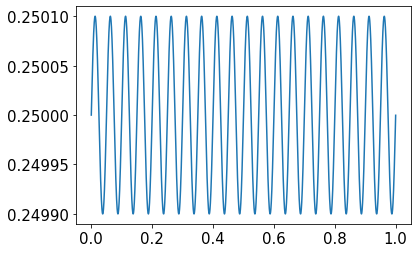

In [1091]:
time_var = df[['time']].values

training_set_param_ca3 = df[['vip', 'vop']].values
df_train = pd.DataFrame(training_set_param_ca3)
df_train = df_train.dropna()
train = df_train.to_numpy()
plt.plot(time_var[:-1], train[:,0])

x_ca3 = train

if np.size(x_ca3,0) % 2 != 0:
    x_ca3 = np.delete(x_ca3, -4, 0)

training_set_labels_ca3 = df[['out+', 'out-']].values
df_lab = pd.DataFrame(training_set_labels_ca3)
df_lab = df_lab.dropna()
label = df_lab.to_numpy()

y_ca3 = scaler_labels.transform(label)
print(time_var)

In [1092]:
# Define the dimensions input
dims = dims_file[0]
dims = np.tile(dims, (x_ca3.shape[0], 1))

dataset = np.concatenate([x_ca3, dims], axis=1)
dataset = scaler_features.transform(dataset)

x_ca3 = dataset[:,0:2]
#plt.plot(time_var[:-2], x_ca3[:,0])
dimension_input = Variable(torch.Tensor(np.array(dataset[:,2:dataset.shape[1]+1])))
dims_vector = dataset[:,2:dataset.shape[1]+1]
#Concat(dims_vector, 28, 150)

In [1093]:
df_x_ca3 = pd.DataFrame(x_ca3)

# One delay line with shift of 1
df_x_ca3_1 = df_x_ca3.shift(1)

# Second delay line with shift of 2
df_x_ca3_2 = df_x_ca3.shift(2)

df_y = pd.DataFrame(y_ca3)

all_df = pd.concat([df_x_ca3, df_x_ca3_1, df_x_ca3_2, df_y], axis = 1)
all_df = all_df.dropna()

all = all_df.to_numpy()
x_ca3 = all[:,0:6]
y_ca3 = all[:,6:all.shape[1]+1]

print(x_ca3.shape)
all_dataX = Variable(torch.Tensor(np.array(x_ca3)))
print(all_dataX.shape)
all_dataY = Variable(torch.Tensor(np.array(y_ca3)))

(90180, 6)
torch.Size([90180, 6])


In [1094]:
# Define the evaluation batchsize
   
BatchSize = np.size(x_ca3,0)
print(BatchSize)

90180


In [1095]:
class Model(nn.Module):
    def __init__(self, in_features=6, h1=150, h2=35, h3 =25, out_features=2): #200,100,25
        super().__init__()
        
        # input layer -> 1 hidden -> 2 hidden -> output 
        self.fc1 = nn.Linear(in_features,h1) # input layer (+28 to include the dimensions)
        self.dropout = nn.Dropout(p = 0.1)
        self.fc2 = nn.Linear(h1 + 28, h2)            # hidden layer
        self.fc3 = nn.Linear(h2,h2)  # output layer
        self.fc4 = nn.Linear(h2,h3)
        self.fc5 = nn.Linear(h3, out_features)  # output layer
                
    def forward(self, x, dimensions):
        x = F.elu(self.fc1(x))
        fc1_elu = x
        in_fc = torch.cat((x.cuda(), dimensions[:-1].cuda()), dim=1).cuda()
        x = F.elu(self.fc2(in_fc))
        x = F.sigmoid(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = self.fc5(x)
        return fc1_elu, x

In [1096]:
torch.manual_seed(4)
model = Model()
model = torch.nn.DataParallel(model, device_ids=[0,1]).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load('/home/aamaral/Desktop/BigDataset/Evaluation/MLP_DelayLine2_Sig_simples_15_napp.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(optimizer.__module__)

torch.optim.adam


In [1104]:
with torch.no_grad():
    model.eval()
    fc1_elu, test_predict = model(all_dataX, dimension_input)

/home/aamaral/.venv/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ValueError: x and y must have same first dimension, but have shapes (90179, 1) and (90180,)

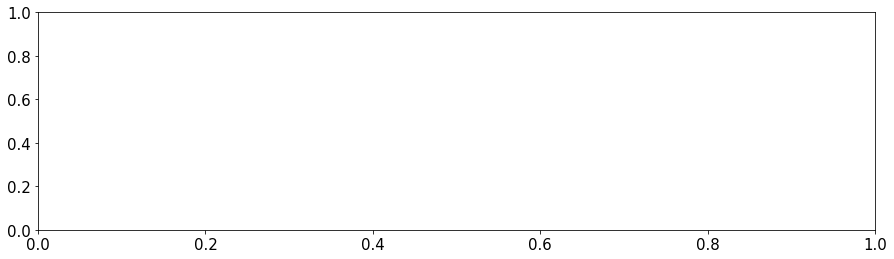

In [1105]:
plt.figure(figsize=(15,4))
fc1_elu = fc1_elu.cpu().data.numpy()
plt.plot(time_var[:-4], fc1_elu[:,33])

In [ ]:
import pandas as pd
df1 = pd.read_csv('a1a.csv')
#df2 = pd.read_csv('wave_ca2_1.csv')
df1.head()

,/a5_s<0> X,/a5_s<0> Y
0,0.000,0.087131
1,0.001,0.087073
2,0.003,0.086945
3,0.007,0.086689
4,0.015,0.086177


ValueError: x and y must have same first dimension, but have shapes (90179, 1) and (90180,)

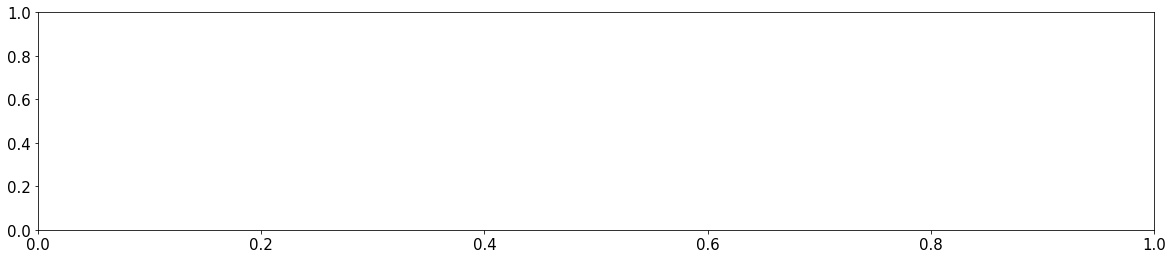

In [1106]:
# Convert the train prediction and the train label to numpy vectors
test_predict = test_predict.cpu().data.numpy()
test_predict = test_predict
test_label_plot = all_dataY.cpu().numpy()

time_plot_pred = time_var[:-4]
time_plot_lab = time_var[:-4]

time = df1['/a5_s<0> X'].to_numpy()
data1 = df1['/a5_s<0> Y']
#data2 = df1['/a4<1> Y']
#data = pd.concat([data1,data2], axis = 1)
data = data1
data = data.to_numpy()

plt.figure(figsize=(20,4))
#plt.plot(time, data[:,0], marker="*", markersize=12, color = 'c')
plt.plot(time_plot_lab, test_label_plot[:,0])
plt.plot(time_plot_pred, test_predict[:,0])
plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Amplitude [V]', fontsize=18)
plt.show()

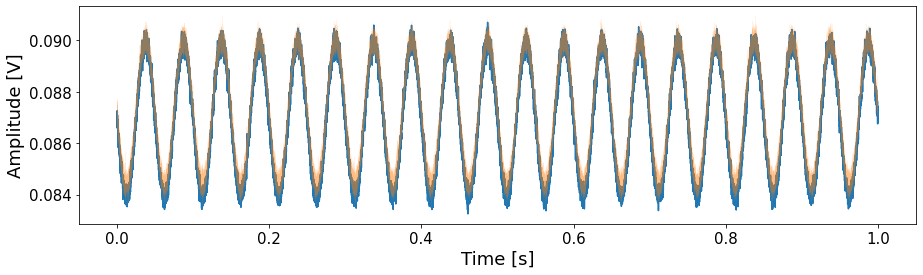

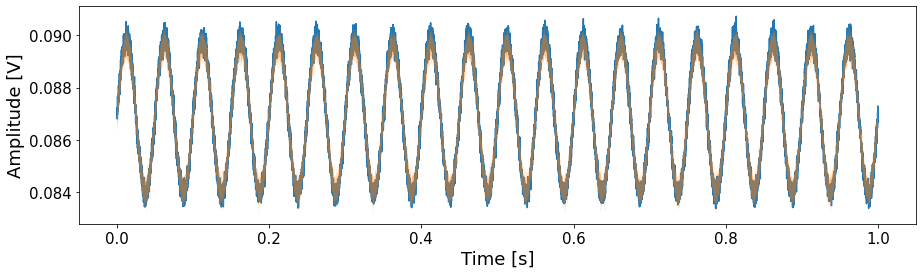

In [1107]:
time_plot_pred = time_var[:-3]
time_plot_lab = time_var[:-3]

test_predict =  scaler_labels.inverse_transform(test_predict)
#test_predict = scaler.inverse_transform(test_predict)

if np.size(test_label_plot,0) % 2 != 0:
    test_label_plot = np.delete(test_label_plot, -1, 0)

#test_label_plot = scaler.inverse_transform(test_label_plot)
test_label_plot =  scaler_labels.inverse_transform(test_label_plot)

#data = scaler.inverse_transform(data)

# Add noise to the predictions
errors_mean = -0.00004383777
errors_stdv = 0.000251118375
noise = np.random.normal(errors_mean,errors_stdv, test_predict.shape) # Create a gaussian noise 
test_predict = test_predict - noise

plt.figure(figsize=(15,4))
plt.plot(time_plot_lab, test_label_plot[:,0])
plt.plot(time_plot_pred, test_predict[:,0], linewidth = 0.09, alpha=0.5)
#plt.plot(time, data, marker="*", markersize=12, color = '#086eff')
plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Amplitude [V]', fontsize=18)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.show()

plt.figure(figsize=(15,4))
plt.plot(time_plot_lab, test_label_plot[:,1])
plt.plot(time_plot_pred, test_predict[:,1], linewidth = 0.09, alpha=0.5)
#plt.plot(time, data[:,0], marker="*", markersize=12, color = '#086eff')
plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Amplitude [V]', fontsize=18)
plt.show()

In [1103]:
np.mean(np.power(abs(test_predict[:,1] - test_label_plot[:,1]),2))

1.3042846483014552e-07

In [733]:
x = model.module.fc1.state_dict()
W = x['weight'].detach().cpu().numpy()
B = x['bias'].detach().cpu().numpy()
print(W)
print(B)
%run Python2VerilogA.ipynb
FC_HiddenLayer_to_VerilogA(W, B, 1, 1)
    

[[ 4.78830487e-01  2.25922540e-01 -3.41582149e-01 -3.07266444e-01
  -5.67681551e-01 -3.60631973e-01]
 [ 6.99822366e-01  2.91218042e-01 -9.26912799e-02  1.62224472e-01
  -5.95936418e-01 -4.36557084e-01]
 [ 3.07105809e-01  7.94117246e-03  1.21064186e-01  2.38585785e-01
   4.02594119e-01 -4.21090811e-01]
 [-4.76632416e-01 -6.21756375e-01  7.00840377e-04  1.12634674e-01
   3.82419787e-02  8.63964558e-02]
 [ 9.38612521e-02  8.62316638e-02  6.44549951e-02  1.47170678e-01
   3.52697849e-01 -3.42825264e-01]
 [ 7.63542131e-02  2.36715212e-01 -2.89788187e-01  1.20622821e-01
   3.77003938e-01 -5.31145990e-01]
 [-5.29166222e-01  8.24019462e-02  3.17041010e-01 -7.76888579e-02
   2.52925515e-01  2.86281798e-02]
 [ 5.65651655e-01 -5.12492180e-01 -9.75076109e-02  2.58641124e-01
   2.30976328e-01 -2.15187401e-01]
 [-2.06156850e-01  5.30120373e-01 -1.77404568e-01  3.07492226e-01
   4.55024391e-01 -5.15259206e-01]
 [-7.11196005e-01  3.58222455e-01  1.04665160e-01  4.90318924e-01
   6.63333908e-02  3.3857

ValueError: x and y must have same first dimension, but have shapes (70125, 1) and (70124,)

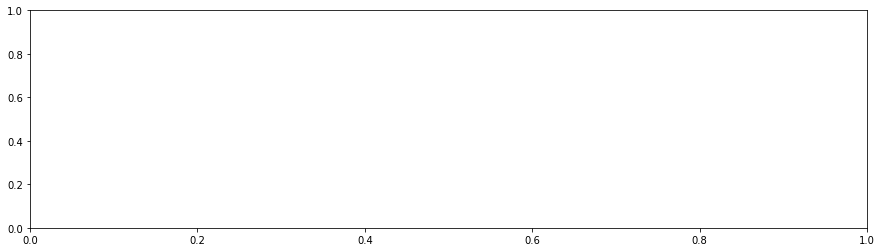

In [ ]:
time_plot_pred = time_var[:-3]
time_plot_lab = time_var[:-4]

plt.figure(figsize=(15,4))
plt.plot(time_plot_pred, fc3_elu[:,49])
print(fc3_elu[:,49].min())

(70124,)


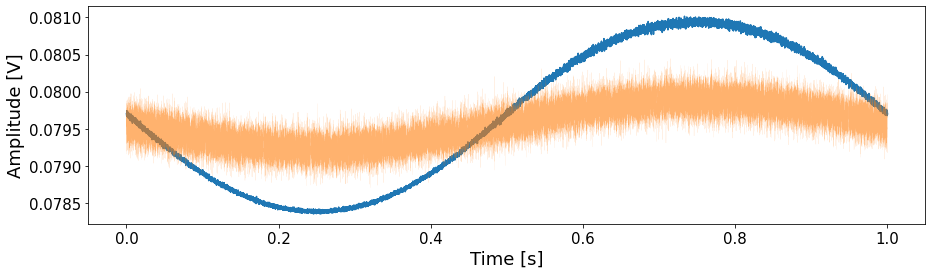

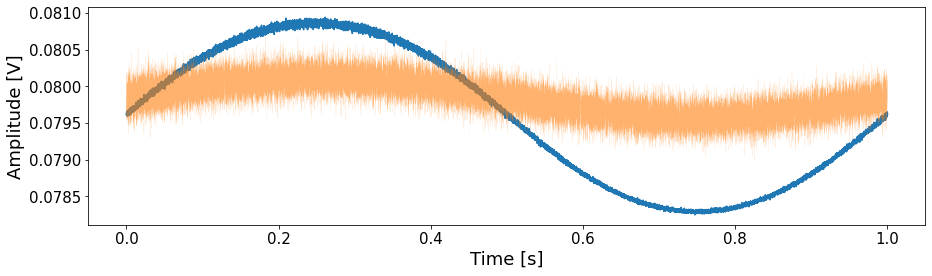

0.08101646
0.08072500638541784
0.0020210337208807355
0.07824647
0.079638936


In [ ]:

time_plot_pred = time_var[:-4]
time_plot_lab = time_var[:-4]


print(test_predict[:,0].shape)
#Plot the graphics with the results
plt.figure(figsize=(15,4))
plt.plot(time_plot_lab, test_label_plot[:,0])
plt.plot(time_plot_pred, test_predict[:,0], linewidth=0.09,alpha=0.6)
plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Amplitude [V]', fontsize=18)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(time_plot_lab,test_label_plot[:,1])
plt.plot(time_plot_pred,test_predict[:,1],  linewidth=0.09,alpha=0.6)
plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Amplitude [V]', fontsize=18)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.show()

print(test_label_plot.max())
print(test_predict.max())
print(test_predict.max() - test_predict.min() )
print(test_label_plot.min())
print(test_label_plot.mean())

In [ ]:
print(0.101191-0.0866728)

0.014518200000000009


In [ ]:
np.mean(np.power(abs(test_predict[:,0] - test_label_plot[:,0]),2))

3.843983002142644e-07